In [1353]:
import torch
import torch.nn as nn

In [1354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [1355]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)
print (device)

cuda


In [1356]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1357]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/newnew_data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # 'Date' 열을 datetime 객체로 변환
df.set_index('Date', inplace=True)
raw_data = df

In [1358]:
# raw_data.drop(['구리','은','유가','원위안','외환보유액'],axis=1, inplace=True)
# raw_data

### MinMaxScaler 적용

In [1359]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_raw_data = X_scaler.fit_transform(raw_data)
y_raw_data = y_scaler.fit_transform(raw_data['종가'].values.reshape(-1, 1))

In [1360]:
X_raw_data.shape

(184, 22)

### X_train 과 y_train 데이터 구성

In [1361]:
def prepare_xy(X_raw_data, y_raw_data, lookback):
    data = list()
    for index in range(len(X_raw_data) - lookback):
        data.append(X_raw_data[index: index + lookback])
    data = np.array(data)
    return data, y_raw_data[lookback:]

In [1362]:
lookback = 1 # sequence length - 1
X_all, y_all = prepare_xy(X_raw_data, y_raw_data, lookback)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
print(X_all.shape, y_all.shape)

torch.Size([183, 1, 22]) torch.Size([183, 1])


In [1363]:
X_train = X_all
y_train = y_all
print (X_train.shape, y_train.shape)

torch.Size([183, 1, 22]) torch.Size([183, 1])


### TensorDataset
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 실제 값 Y를 묶어 놓는 Dataset
   - 학습 데이터와 실제 값을 하나로 묶어서, 인덱스, 반복문을 통한 각 데이터 추출을 편리하게 하는 기능
   - DataLoader 등 pytorch 의 데이터 전처리 기능 사용 가능
- TensorDataset으로 랩핑한 Dataset 은 DataLoader 로 미니배치를 쉽게 작성할 수 있음
- tensors() 메서드로 각 텐서를 인덱스 번호로 엑세스도 가능함

In [1364]:
train_rawdata = TensorDataset(X_train, y_train)

In [1365]:
print (train_rawdata.tensors[0].shape) # X_train
print (train_rawdata.tensors[1].shape) # y_train

torch.Size([183, 1, 22])
torch.Size([183, 1])


In [1366]:
# VALIDATION_RATE = 0.2
# train_indices, val_indices = train_test_split(
#     range(len(train_rawdata)), # X index 번호
#     test_size=VALIDATION_RATE # test dataset 비율
# )
# train_dataset = Subset(train_rawdata, train_indices)
# validation_dataset = Subset(train_rawdata, val_indices)

num_samples = len(train_rawdata)
num_val = 36
num_train = num_samples - num_val

train_indices = range(num_train) # 처음부터 마지막 36개 데이터 직전까지가 훈련 데이터
val_indices = range(num_train, num_samples) # 마지막 36개 데이터가 검증 데이터

train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)




minibatch_size = 8 # Mini-batch 사이즈는 128 로 설정
# create batches
train_batches = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=minibatch_size, shuffle=True)
print(f"Train indices: {list(train_indices)}")
print(f"Validation indices: {list(val_indices)}")

Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
Validation indices: [147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]


In [1367]:
# 미니배치 하나만 가져와서 이미지 visualization
X_train, y_train = next(iter(train_batches))
print (X_train.shape, y_train.shape)

torch.Size([8, 1, 22]) torch.Size([8, 1])


### 모델 생성

In [1368]:
class Net(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout_p, output_size):
        super().__init__()
        self.sequenceclassifier = nn.LSTM(
            input_size = 32,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout_p,
            bidirectional = True
        )
        self.fc = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(hidden_size*2),
            nn.Linear(hidden_size*2, output_size)
        )
        self.ELU = nn.ELU(alpha=1.0)
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=32, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1) # Conv1d takes (batch, channel, seq_len)
        x = self.conv1(x)
        x = x.permute(0, 2, 1) # LSTM takes (batch, seq_len, channel)


        output, _ = self.sequenceclassifier(x)
        output = output[:, -1, :]
        output = self.ELU(output)
        y = self.fc(output)
        return y

### input, output, loss, optimizer 설정

In [1369]:
feature_size = 22 # 입력 차원
hidden_size = 128 # Hidden Layer 사이즈 설정처럼 설정
num_layers = 4 # stacked RNN (최대 4개까지는 Gradient Vanishing 현상이 적을 수 있으므로)
dropout_p = 0 # dropout rate
output_size = 1

model = Net(feature_size, hidden_size, num_layers, dropout_p, output_size).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

### training 함수 선언

In [1370]:
def train_model(model, early_stop, n_epochs, progress_interval):

    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(n_epochs):
        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_batches:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            y_minibatch_pred = model(x_minibatch)
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.to(device)
                y_minibatch_pred = model(x_minibatch)
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_losses.append(loss.item())

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                model.load_state_dict(best_model)
                break

        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)

    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses

In [1371]:
nb_epochs = 500
progress_interval = 3
early_stop = 100

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.01353814359754324 0.04733317345380783 0.04733317345380783 0 0
0.05983896553516388 0.12942081689834595 0.04733317345380783 0 3
0.0016439552418887615 0.006443474907428026 0.006443474907428026 6 6
0.0522259883582592 0.104514941573143 0.006443474907428026 6 9
0.03751947730779648 0.06294474750757217 0.006443474907428026 6 12
0.020985683426260948 0.13772264122962952 0.006443474907428026 6 15
0.013349786400794983 0.02898242138326168 0.006443474907428026 6 18
0.06130614131689072 0.04753081500530243 0.006443474907428026 6 21
0.10320308804512024 0.03427989035844803 0.006443474907428026 6 24
0.14747673273086548 0.017392663285136223 0.006443474907428026 6 27
6.469974323408678e-05 0.006817894987761974 0.006443474907428026 6 30
0.143971249461174 0.01855597458779812 0.006443474907428026 6 33
0.08202797919511795 0.06377245485782623 0.006443474907428026 6 36
0.056005626916885376 0.0643383264541626 0.006443474907428026 6 39
0.005879224743694067 0.041168197989463806 0.006443474907428026 6 42
0.00503682

In [1372]:
test_rawdata = TensorDataset(X_all[147:], y_all[147:])
test_batches = DataLoader(test_rawdata, batch_size=minibatch_size)
y_test_pred_list, y_test_list = list(), list()
model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batches:
        x_minibatch = x_minibatch.to(device)
        y_minibatch = y_minibatch.to(device)
        y_minibatch_pred = model(x_minibatch)
        y_test_pred_list.append(y_minibatch_pred)
        y_test_list.append(y_minibatch)
y_test_preds = torch.cat(y_test_pred_list, 0)
y_tests = torch.cat(y_test_list, 0)
print (y_test_preds.shape, y_tests.shape)

torch.Size([36, 1]) torch.Size([36, 1])


In [1373]:
predict = pd.DataFrame(y_scaler.inverse_transform(np.array(y_test_preds.detach().cpu())))
original = pd.DataFrame(y_scaler.inverse_transform(np.array(y_tests.detach().cpu())))

In [1374]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(original[0], predict[0])**0.5
print (RMSE)

137.14004731705833


In [1375]:
predict_1000 = predict[:1000]
original_1000 = original[:1000]

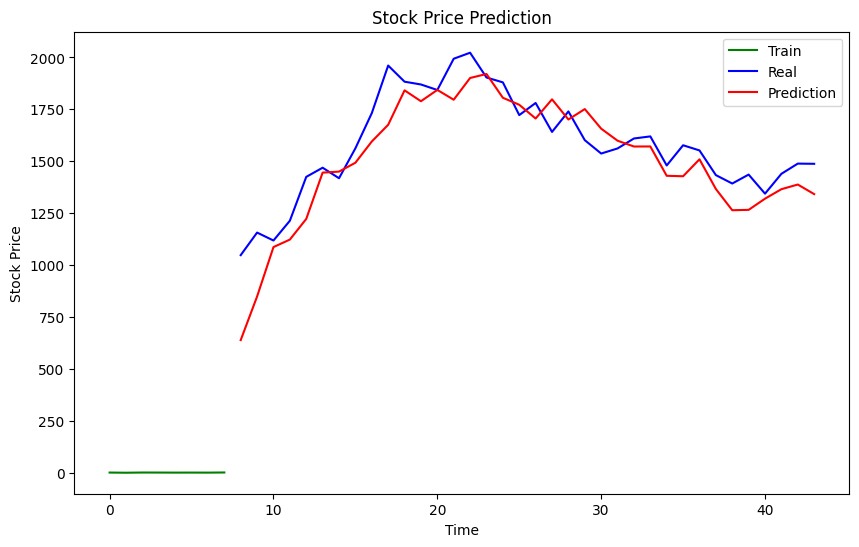

In [1376]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))

# Add the training set to the plot:
plt.plot(y_train.numpy().flatten(), color='green', label='Train')

# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(original)), original, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train) + len(original)), predict, color='red', label='Prediction')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [1377]:
# 두 데이터프레임을 'Index' 컬럼을 기준으로 합침
data = pd.merge(predict, original, left_index=True, right_index=True)

# 컬럼 이름 변경
data = data.rename(columns={'0_x': '예측', '0_y': '종가'})

In [1378]:
# data['예측'] = data['예측'].pct_change()
# data['종가'] = data['종가'].pct_change()

In [1379]:
# re = 1

# for i in range(1, len(data)):
#     if data.loc[i, '예측'] > 0:
#         re *= (1 + data.loc[i, '종가'])

# re

In [1380]:
data['trade'] = ''
data['trade'] = np.where(data['예측'].shift(-1) > data['예측'], 'buy', '')
data['buy_price'] = data.loc[data['trade'] == 'buy', '종가']
data['next_day_price'] = data['종가'].shift(-1)  # 다음 날의 종가를 새로운 컬럼으로 추가
data['profit'] = np.where(data['trade'] == 'buy', data['next_day_price'] - data['buy_price'], np.nan)  # 수익 계산
data['return'] = data['profit'] / data['buy_price']  # 수익률 계산
data['profit'] = data['profit'].fillna(0)
data['return'] = data['return'].fillna(0)
data

,예측,종가,trade,buy_price,next_day_price,profit,return
0,638.475464,1047.709961,buy,1047.709961,1156.359985,108.650024,0.103702
1,848.598877,1156.359985,buy,1156.359985,1118.170044,-38.189941,-0.033026
2,1086.533569,1118.170044,buy,1118.170044,1213.420044,95.250000,0.085184
3,1122.655640,1213.420044,buy,1213.420044,1424.679932,211.259888,0.174103
4,1222.183960,1424.679932,buy,1424.679932,1468.869995,44.190063,0.031018
5,1445.154907,1468.869995,buy,1468.869995,1418.119995,-50.750000,-0.034550
6,1450.126221,1418.119995,buy,1418.119995,1562.349976,144.229980,0.101705
7,1492.823242,1562.349976,buy,1562.349976,1731.680054,169.330078,0.108382
8,1595.067871,1731.680054,buy,1731.680054,1960.990112,229.310059,0.132421
9,1675.641113,1960.990112,buy,1960.990112,1883.220093,-77.770020,-0.039659


In [1381]:
ret = 1
cum_ret = []
for index, value in data['return'].iteritems():
  if not pd.isnull(value):
    ret *= (1+value)
    cum_ret.append(ret)
data['누적 수익률'] = cum_ret
data

<ipython-input-1381-3b58f46879da>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in data['return'].iteritems():


,예측,종가,trade,buy_price,next_day_price,profit,return,누적 수익률
0,638.475464,1047.709961,buy,1047.709961,1156.359985,108.650024,0.103702,1.103702
1,848.598877,1156.359985,buy,1156.359985,1118.170044,-38.189941,-0.033026,1.067252
2,1086.533569,1118.170044,buy,1118.170044,1213.420044,95.250000,0.085184,1.158164
3,1122.655640,1213.420044,buy,1213.420044,1424.679932,211.259888,0.174103,1.359804
4,1222.183960,1424.679932,buy,1424.679932,1468.869995,44.190063,0.031018,1.401982
5,1445.154907,1468.869995,buy,1468.869995,1418.119995,-50.750000,-0.034550,1.353543
6,1450.126221,1418.119995,buy,1418.119995,1562.349976,144.229980,0.101705,1.491205
7,1492.823242,1562.349976,buy,1562.349976,1731.680054,169.330078,0.108382,1.652824
8,1595.067871,1731.680054,buy,1731.680054,1960.990112,229.310059,0.132421,1.871692
9,1675.641113,1960.990112,buy,1960.990112,1883.220093,-77.770020,-0.039659,1.797463


In [1382]:
# 데이터 불러오기
df_origin = pd.read_csv('/content/drive/MyDrive/newnew_data.csv')
df_origin['Date'] = pd.to_datetime(df_origin['Date'])  # 'Date' 열을 datetime 객체로 변환
df_origin.set_index('Date', inplace=True)

y_train = df_origin[:148]
y_train = y_train['종가'].values
y_train

array([1000.  ,  897.97,  873.82,  965.78, 1056.74, 1031.71,  932.16,
        914.44,  863.49,  880.53,  678.15,  575.08,  628.67,  631.95,
        577.77,  709.1 ,  833.44,  878.96,  880.13, 1006.47, 1123.29,
       1127.68, 1103.06, 1092.66, 1227.93, 1153.81, 1169.97, 1222.82,
       1293.87, 1312.15, 1362.07, 1474.62, 1465.26, 1648.14, 1823.81,
       1835.62, 1877.66, 1807.19, 1780.47, 2044.7 , 2340.18, 2314.34,
       2368.46, 2395.14, 2107.47, 2038.14, 2170.86, 2102.65, 2000.27,
       2050.13, 2083.85, 2151.5 , 2261.52, 2071.67, 2053.74, 2068.6 ,
       2125.45, 2123.16, 1896.97, 1990.03, 1962.97, 1908.85, 2020.26,
       2015.85, 1865.67, 1985.14, 1960.07, 2005.59, 2053.49, 2132.54,
       2144.66, 2148.85, 1993.11, 2048.08, 2114.37, 2163.52, 2044.01,
       2074.26, 2062.72, 2195.06, 2161.39, 1964.34, 1793.43, 1876.21,
       1796.73, 1801.27, 1759.67, 1762.54, 1845.54, 1785.16, 1690.07,
       1705.79, 1716.38, 1820.41, 1795.81, 1761.01, 1666.85, 1668.47,
       1733.02, 1682

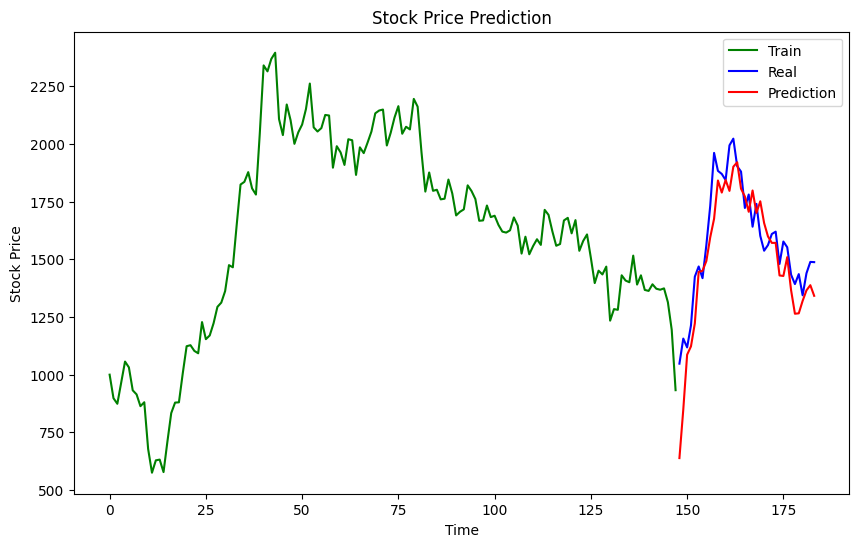

In [1383]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))

# Add the training set to the plot:
plt.plot(y_train, color='green', label='Train')

# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(original)), original, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train) + len(original)), predict, color='red', label='Prediction')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()